<a id="1"></a>
# AR Models

## Table of Contents

- **[AR Models](#1)**
- **[Model for Los Angeles County](#2)**
- **[Predicitons](#3)**

In this section, we created AR (auto-regressive) models on the select counties we established. We chose to explore AR models as it will calculate the regression of past AQI scores and calculate the predicted AQI score. We want to be considerate of previous AQI scores.

After reviewing quarterly PACF a seasonal cycled was observed which confirmed AR to be a significant parameter for our model. Based on where the lag occurred, the baseline value for AR should be AR(1).

In [1]:
# import libraries
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [2]:
# import df
df = pd.read_csv('./Datasets/cleaned_df.csv')

# change date column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


# confirm this worked
df.head()

,state_name,county_name,county_code,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
date,,,,,,,,
2013-01-01,California,Alameda,1,62,Moderate,PM2.5,06-001-0007,4
2013-01-02,California,Alameda,1,61,Moderate,PM2.5,06-001-0007,4
2013-01-03,California,Alameda,1,81,Moderate,PM2.5,06-001-0007,4
2013-01-04,California,Alameda,1,78,Moderate,PM2.5,06-001-0007,4
2013-01-05,California,Alameda,1,84,Moderate,PM2.5,06-001-0007,4


#### Counties

We opted to create a counties list of the five most populous counties. These five counties account for half the population of California. Given the model is being built to include for products sold in California, we felt running the test over half the population of the state would be a good place to start.

In [3]:
# set the list of top 5 counties by population
counties = ['Los Angeles', 'San Diego',
            'Orange', 'Riverside', 'San Bernardino']

<a id="2"></a>
#### Model for Los Angeles County

In order to compare a baseline of models before determining which model to pursue, all three models are being built against Los Angeles to compare which model performs. This county accounts for some of the highest AQI readings and population is roughly one fourth of the state's population.

In [227]:
# establish mask
mask = df[df['county_name'] == 'Los Angeles']

mask = mask.sort_index()

# create training and testing df's
train = mask.loc['2010-01-01':'2018-12-31']
test = mask.loc['2019-01-01':'2019-12-31']

# create training variables
#train_vals = train['aqi'].values
#train_dates = train.index

# create testing variables
#test_vals = test['aqi'].values
#test_dates = test.index

# fit the model on training data
ar = AR(endog=train['aqi']).fit()
#model = ar(train_vals, train_dates).fit()

# print aic score
print(ar.aic)

6.283758967842975


/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


From the AR model built only on for Los Angeles county, the AIC returned a score of just above 6. This is a great score but in order to confirm this is not a fluke in the data, we will check the score over the five counties previously shown.

In order to streamline this process we will create a function to streamline the model creation process for each county.

#### Function

---
In this section we built a function to streamline the AR model creation for each county. We then ran the model on the five counties that compose of half the population of California.

In [290]:
# define function to take in a county name ARIMA params. this allows us to check AR and ARMA models based on the order entered in a ARIMA model
def ar_county(county, train_date_start, train_date_cutoff, test_date_start, test_date_cutoff):

    # establish mask
    mask = df[df['county_name'] == county]

    mask = mask.sort_index()

    # create training and testing df's
    train = mask.loc[train_date_start:train_date_cutoff, ]
    test = mask.loc[test_date_start:test_date_cutoff, ]

    # create training variables
    train_vals = train['aqi'].dropna().values
    train_dates = train.index

    # create testing variables
    test_vals = test['aqi'].dropna().values
    test_dates = test.index

    # fit the model on training data
    model = AR(train_vals).fit()

    # print aic score
    print(f'The AIC for the AR model built for {county} county is {model.aic}')

    # print
    # print(ar.summary().tables[1])

    # generate predictions off the model
    pred = ar.predict(dynamic=False, start=test_dates[0], end=test_dates[-1])

    # calculate RMSE and show the score
    rmse = metrics.mean_squared_error(test['aqi'], pred, squared=False)
    print(f'The RMSE for the AR model for {county} is {rmse}')

    ax = mask['aqi'].plot(label='observed', alpha=0.75)
    pred.to_frame(name='Forecast').plot(
        ax=ax, label='Forecast', figsize=(14, 7), color='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.title(f'Forecast for {county}')
    plt.legend()
    plt.show()

    # generate predictions off the model using dynamic forecasting
    pred = ar.predict(dynamic=True, start=test_dates[0], end=test_dates[-1])

    # calculate RMSE and show the score
    rmse = metrics.mean_squared_error(test['aqi'], pred, squared=False)
    print(
        f'The RMSE with Dynamic Forecasting for the AR model for {county} is {rmse}')

    ax = mask['aqi'].plot(label='observed', alpha=0.75)
    pred.to_frame(name='Forecast').plot(
        ax=ax, label='Dynamic Forecast', figsize=(14, 7), color='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.title(f'Dynamic Forecast for {county}')
    plt.legend()
    plt.show()

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for Los Angeles county is 6.283758967842975
The RMSE for the AR model for Los Angeles is 36.4202868013198


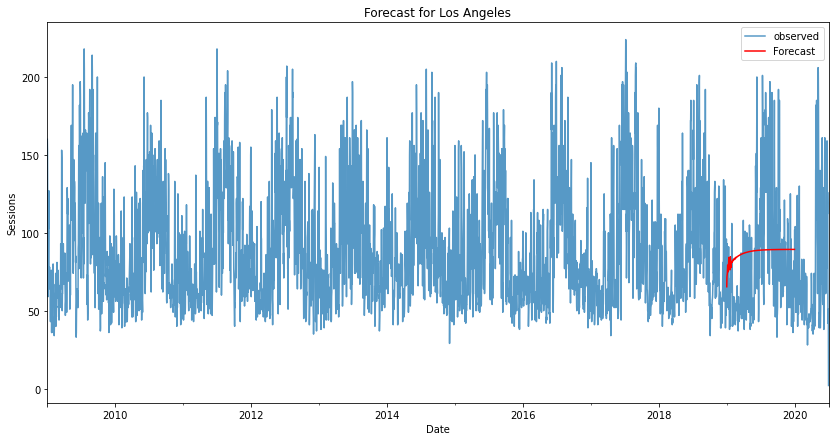

The RMSE with Dynamic Forecasting for the AR model for Los Angeles is 36.4202868013198


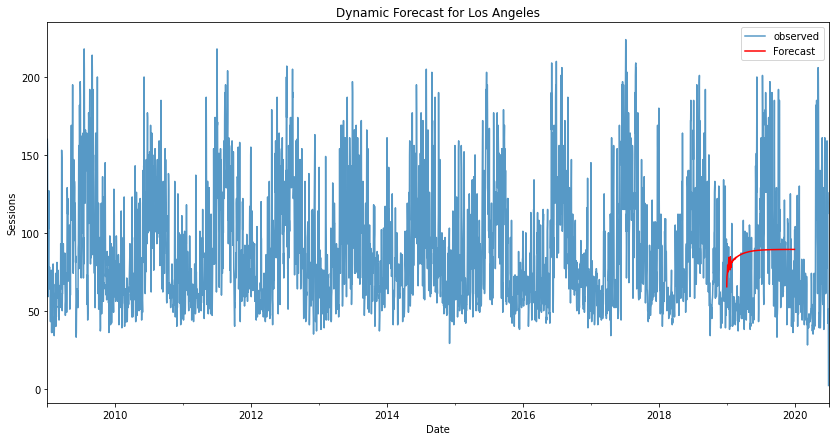

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for San Diego county is 6.08672995613337
The RMSE for the AR model for San Diego is 28.9843324430387


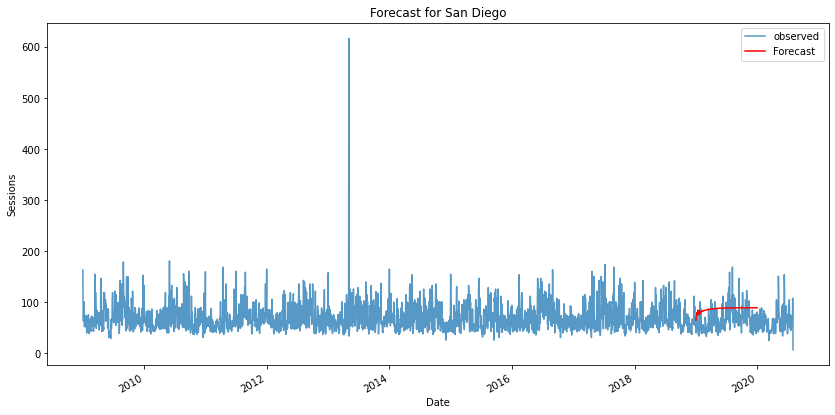

The RMSE with Dynamic Forecasting for the AR model for San Diego is 28.9843324430387


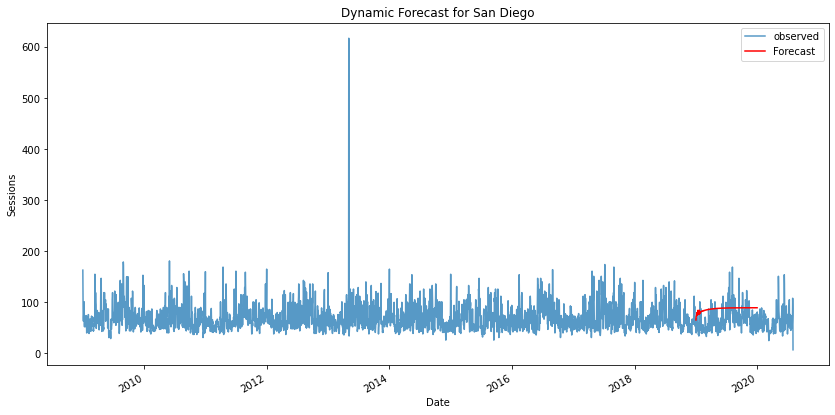

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for Orange county is 5.547578661840185
The RMSE for the AR model for Orange is 38.62228012071251


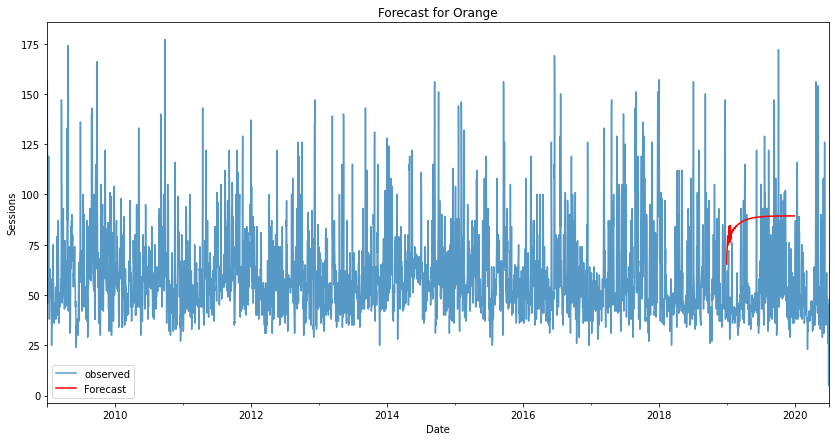

The RMSE with Dynamic Forecasting for the AR model for Orange is 38.62228012071251


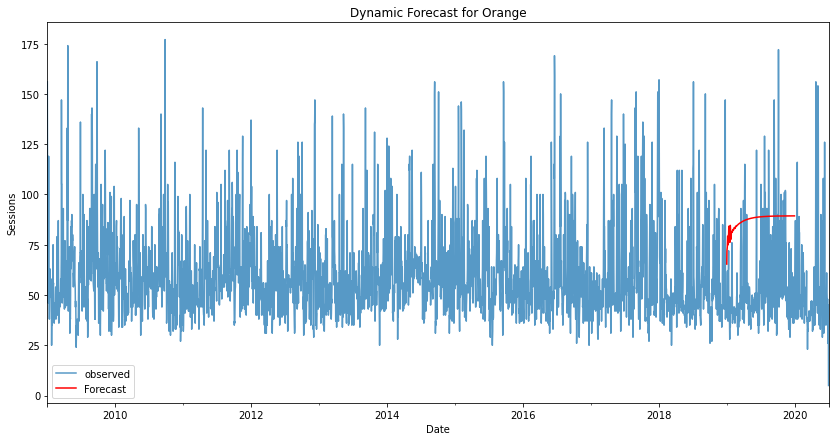

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for Riverside county is 6.95803303410269
The RMSE for the AR model for Riverside is 37.002523616765416


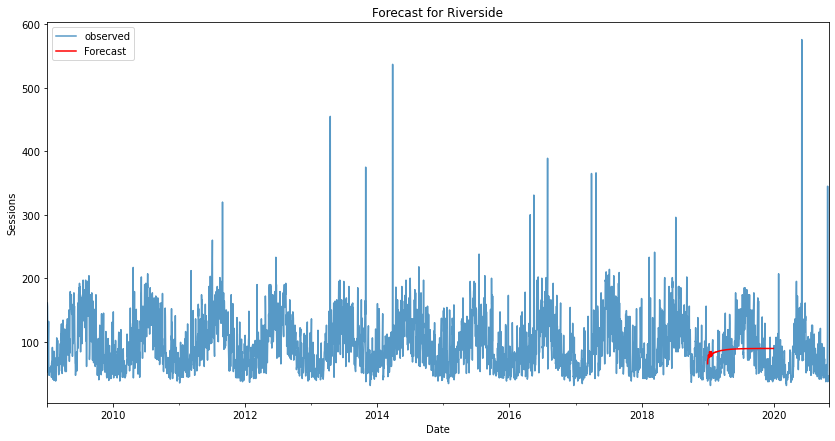

The RMSE with Dynamic Forecasting for the AR model for Riverside is 37.002523616765416


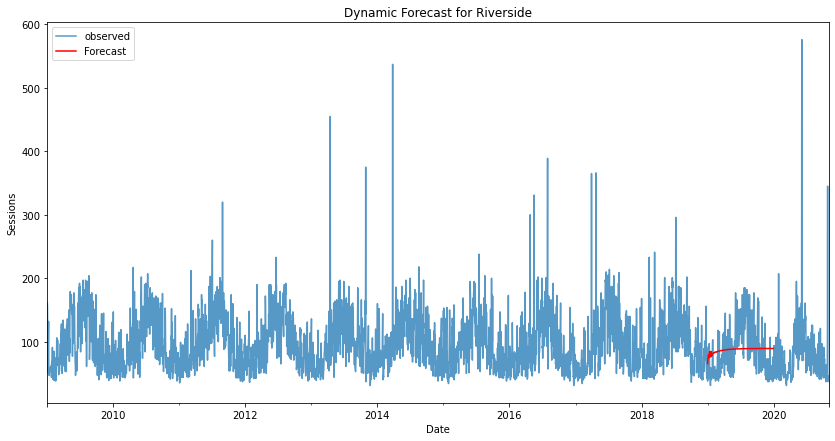

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for San Bernardino county is 6.411575143018856
The RMSE for the AR model for San Bernardino is 47.00159256821194


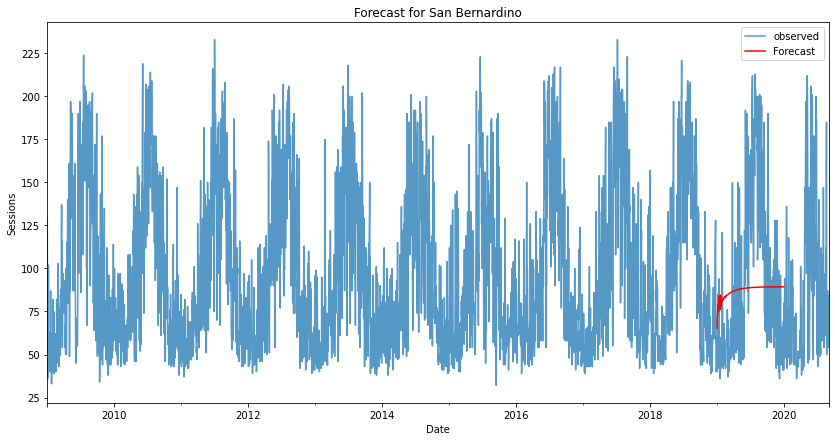

The RMSE with Dynamic Forecasting for the AR model for San Bernardino is 47.00159256821194


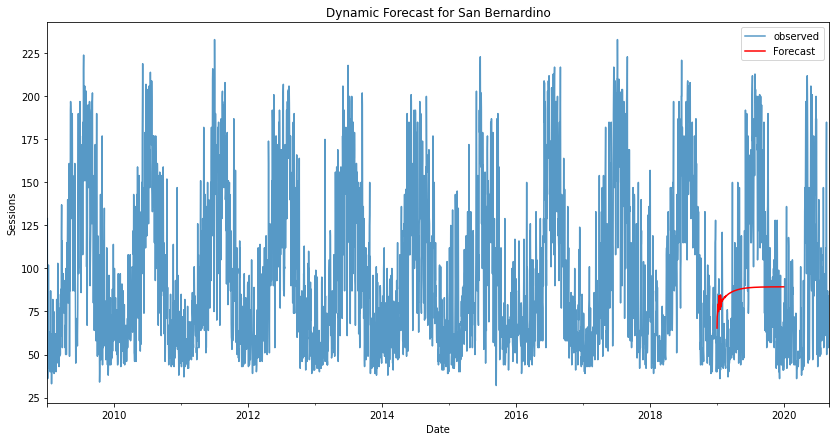

In [291]:
for i in counties:
    ar_county(i, '2010-01-01', '2018-12-31', '2019-01-01', '2019-12-31')

From the above we see that all five counties had AIC scores of below 7 and root mean squared error (RMSE) was between 28 and 47. The AIC score is great but the RMSE is not as low as we would expect given the AIC score.

We will run predictions and model on just the LA data as we are comparing this window and county with other models concurrently before deciding which model to use for all counties.

<a id="3"></a>
#### Predictions

___
In this section we built out predictions for the year 2019 in Los Angeles county AR model. We will evaluate the results here with the other models being built to determine which model can best perform on all counties.

We used RMSE as the main optimization metric because the units that RMSE return are the same units as the output variable. We chose to use the RMSE as a way to manually include a confidence interval for models that do not have that built in.

We created a RMSE-moving-average as we also wanted to measure the RMSE over the first seven days of the prediction as that is the window we are forecasting.

In [292]:
# generate predictions off the model
pred = ar.predict(dynamic=True, start=test.index[0], end=test.index[-1])

In [293]:
# calculate RMSE and show the score
rmse = metrics.mean_squared_error(test['aqi'], pred, squared=False)

# show the RMSE
print(f'The RMSE for the AR model for LA is {rmse}')

The RMSE for the AR model for LA is 36.4202868013198


In [294]:
# create a function that will calculate RMSE on a specified interval rather than entire prediction window
# we chose to do this as our model is forecasting for a full year but we are only looking for forcasting results
# in the next 7 days
def rmse_ma(true_val, pred, n):
    return (sum((true_val[:n] - pred[:n]) ** 2)/n)**(1/2)

In [295]:
rmse_ma(test['aqi'], pred, 7)

16.719448913634082

The RMSE for the first 7 days of predictions is 16.719. This will be used to compare to the ARIMA and SARIMA models.

#### Visualize the Predictions

___
This section will visualize the forecasted values with a confidence interval and the forecasted values against the 

In [296]:
# create a list of rmse scores where the index refers to the prediction index
ci = []

# loop through one full year worth of dates
for i in range(1, 366):

    # run rmse function created to obtain rmse scores
    ci.append(rmse_ma(test['aqi'], pred, i))

# create an empty list for upper bound of CI
upper = []

# loop through predicted values and add the rmse at that index value to create upper bound
for i in range(len(pred)):
    upper.append(pred[i] + ci[i])

# same as aboveloop through predicted values and subtract the rmse at that index value to create lower bound
lower = []
for i in range(len(pred)):
    lower.append(abs(pred[i] - ci[i]))

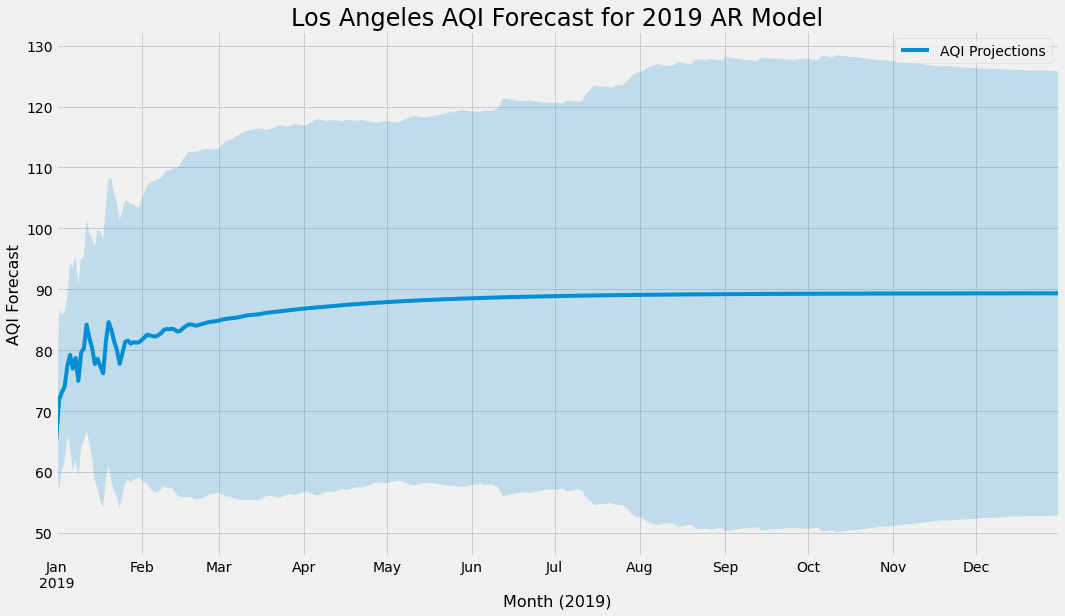

In [311]:
# graphically show the predictions with the rmse-ma as the upper and lower limits
ax = pred.to_frame('AQI Projections').plot(figsize=(16, 9))

# use fill_between and the previously made upper and lower list
ax.fill_between(x=pred.to_frame().index,
                y1=upper,
                y2=lower, alpha=0.2)

# add title, x/y-axis label
plt.title("Los Angeles AQI Forecast for 2019 AR Model", fontsize=24)
plt.xlabel('Month (2019)', fontsize=16)
plt.ylabel("AQI Forecast", fontsize=16)

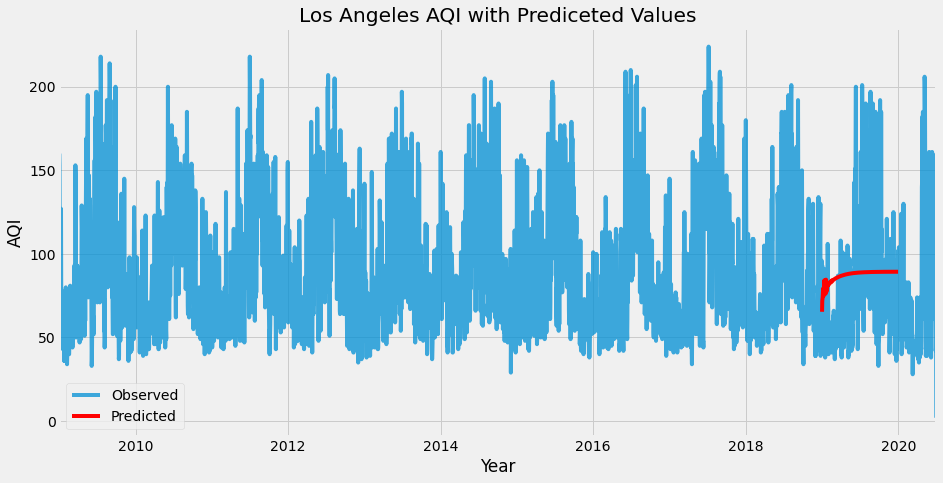

In [307]:
# plot all the data
ax = mask['aqi'].plot(label='Observed', alpha=0.75)

# plot the predicted values over the window they were predicted
pred.to_frame(name='Predicted').plot(
    ax=ax, label='Predicted', figsize=(14, 7), color='red')

# title, x/y labels
plt.title('Los Angeles AQI with Prediceted Values AR Model')
ax.set_xlabel('Year')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

/Users/qghaemi/opt/miniconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

The AIC for the AR model built for Los Angeles county is 6.283758967842975
The RMSE for the AR model for Los Angeles is 36.4202868013198


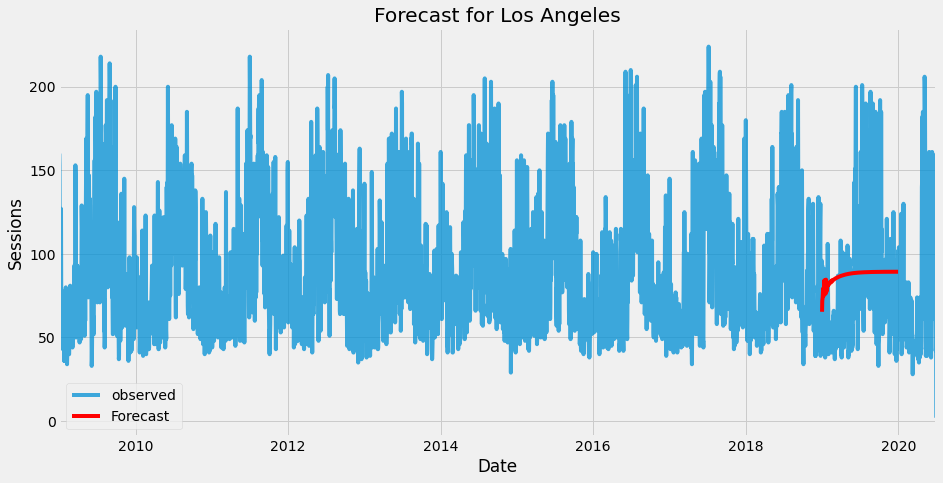

The RMSE with Dynamic Forecasting for the AR model for Los Angeles is 36.4202868013198


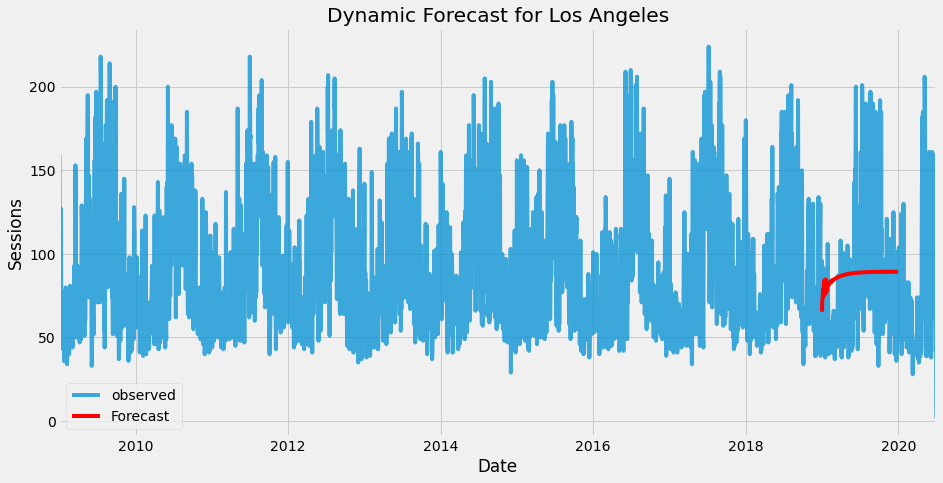

In [309]:
ar_county('Los Angeles', '2010-01-01',
          '2018-12-31', '2019-01-01', '2019-12-31')